<a href="https://colab.research.google.com/github/hksantosh/sscm/blob/main/capstone/Intelligent_Supplier_Selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intelligent Supplier Selection - Capstone Project

## Import Libraries & Data

In [5]:
!pip install ortools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ortools.linear_solver import pywraplp

from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_validate, train_test_split

# Import models
from sklearn import svm, tree
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.ensemble import VotingClassifier, ExtraTreesClassifier, RandomForestClassifier

In [7]:
from google.colab import data_table

pd.set_option('display.max_columns', None)

data_table.enable_dataframe_formatter()
data_table.max_columns = 30

### Import Data

In [8]:
# read file
DF = pd.read_csv('supplier-data.csv')
DF = DF.set_index('Supplier ID')

In [9]:
DF

,Cost,Quality,Delivery time,Reliability,Flexibility,Capacity,Innovation,Reputation,Financial stability,Environmental impact,Social responsibility,Safety record,Technical expertise,Customer service,Lead time,Responsiveness,Contract terms,Diversity,Sustainability,Scalability,Supplier’s default
Supplier ID,,,,,,,,,,,,,,,,,,,,,
1001,0.874,0.758,0.082,0.114,0.082,0.871,0.240,Bad,0.478,0.806,0.359,0.130,0.947,0.463,0.969,0.044,0.812,0.044,0.853,0.663,1
1002,0.972,0.694,0.955,0.963,0.244,0.849,0.001,Good,0.713,0.776,0.759,0.033,0.242,0.867,0.523,0.583,0.968,0.490,0.515,0.028,2
1003,0.827,0.413,0.199,0.577,0.127,0.232,0.476,Excellent,0.805,0.465,0.549,0.060,0.192,0.446,0.145,0.568,0.081,0.822,0.826,0.158,2
1004,0.422,0.555,0.969,0.760,0.773,0.011,0.358,Average,0.847,0.091,0.054,0.209,0.280,0.699,0.863,0.423,0.271,0.960,0.469,0.914,1
1005,0.767,0.958,0.915,0.719,0.715,0.553,0.651,Bad,0.578,0.989,0.219,0.351,0.131,0.406,0.963,0.939,0.981,0.004,0.013,0.575,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1996,0.201,0.260,0.060,0.823,0.220,0.745,0.614,Average,0.804,0.543,0.892,0.269,0.010,0.502,0.154,0.547,0.407,0.813,0.135,0.277,1
1997,0.128,0.408,0.611,0.774,0.351,0.615,0.114,Bad,0.359,0.910,0.016,0.507,0.652,0.212,0.135,0.596,0.996,0.081,0.069,0.905,1
1998,0.910,0.308,0.381,0.818,0.671,0.500,0.031,Average,0.374,0.734,0.469,0.470,0.401,0.677,0.072,0.744,0.520,0.748,0.069,0.403,1


In [10]:
DF.shape

(1000, 21)

In [11]:
DF.describe()

,Cost,Quality,Delivery time,Reliability,Flexibility,Capacity,Innovation,Financial stability,Environmental impact,Social responsibility,Safety record,Technical expertise,Customer service,Lead time,Responsiveness,Contract terms,Diversity,Sustainability,Scalability,Supplier’s default
count,1000.000000,999.000000,1000.000000,998.000000,998.000000,999.000000,998.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,999.000000,999.000000,1000.000000,999.000000,999.000000,1000.000000
mean,0.487184,0.510847,0.500643,0.513186,0.503326,0.505993,0.518637,0.491741,0.513256,0.506644,0.500012,0.504658,0.497444,0.494643,0.489079,0.500069,0.501644,0.500696,0.497949,1.272000
std,0.289946,0.283552,0.294141,0.285107,0.294474,0.286334,0.286429,0.290615,0.290597,0.290358,0.291850,0.294110,0.284664,0.283233,0.290497,0.293173,0.285467,0.294314,0.292739,0.445213
min,0.001000,0.001000,0.000000,0.003000,0.003000,0.001000,0.001000,0.000000,0.001000,0.000000,0.000000,0.001000,0.001000,0.000000,0.001000,0.002000,0.000000,0.001000,0.002000,1.000000
25%,0.236500,0.276000,0.233000,0.271000,0.244000,0.262000,0.272500,0.230000,0.259000,0.245750,0.240000,0.247750,0.253750,0.250750,0.229500,0.240500,0.263750,0.239500,0.249000,1.000000
50%,0.481500,0.506000,0.503000,0.511500,0.511000,0.508000,0.529500,0.487000,0.530000,0.517500,0.515000,0.495500,0.487500,0.494000,0.486000,0.508000,0.507500,0.496000,0.487000,1.000000
75%,0.735250,0.753000,0.761750,0.760750,0.762000,0.746000,0.767750,0.742250,0.767250,0.748250,0.750000,0.768250,0.750000,0.734250,0.749500,0.764500,0.744250,0.746000,0.767000,2.000000
max,0.999000,0.994000,0.999000,0.998000,0.997000,1.000000,0.998000,0.998000,0.999000,0.999000,1.000000,0.998000,1.000000,1.000000,0.998000,1.000000,0.999000,0.999000,1.000000,2.000000


## Data Pre-Processing

### 1. Replace 1 with 0 and 2 with 1 in the target column (Supplier's Default)
With this data change, defaulters will now be the positive class in dataset

In [12]:
DF['Supplier’s default'] = DF['Supplier’s default'].replace([1], 0)
DF['Supplier’s default'] = DF['Supplier’s default'].replace([2], 1)
DF.head()

,Cost,Quality,Delivery time,Reliability,Flexibility,Capacity,Innovation,Reputation,Financial stability,Environmental impact,Social responsibility,Safety record,Technical expertise,Customer service,Lead time,Responsiveness,Contract terms,Diversity,Sustainability,Scalability,Supplier’s default
Supplier ID,,,,,,,,,,,,,,,,,,,,,
1001,0.874,0.758,0.082,0.114,0.082,0.871,0.240,Bad,0.478,0.806,0.359,0.130,0.947,0.463,0.969,0.044,0.812,0.044,0.853,0.663,0
1002,0.972,0.694,0.955,0.963,0.244,0.849,0.001,Good,0.713,0.776,0.759,0.033,0.242,0.867,0.523,0.583,0.968,0.490,0.515,0.028,1
1003,0.827,0.413,0.199,0.577,0.127,0.232,0.476,Excellent,0.805,0.465,0.549,0.060,0.192,0.446,0.145,0.568,0.081,0.822,0.826,0.158,1
1004,0.422,0.555,0.969,0.760,0.773,0.011,0.358,Average,0.847,0.091,0.054,0.209,0.280,0.699,0.863,0.423,0.271,0.960,0.469,0.914,0
1005,0.767,0.958,0.915,0.719,0.715,0.553,0.651,Bad,0.578,0.989,0.219,0.351,0.131,0.406,0.963,0.939,0.981,0.004,0.013,0.575,0


### 2. Null Value Check & Data Imputation

In [13]:
# Check Null values
print(DF.isnull().sum())

## Drop rows with null values
DF = DF.dropna()

print(DF.isnull().sum())

Cost                     0
Quality                  1
Delivery time            0
Reliability              2
Flexibility              2
Capacity                 1
Innovation               2
Reputation               2
Financial stability      0
Environmental impact     0
Social responsibility    0
Safety record            0
Technical expertise      0
Customer service         0
Lead time                0
Responsiveness           1
Contract terms           1
Diversity                0
Sustainability           1
Scalability              1
Supplier’s default       0
dtype: int64
Cost                     0
Quality                  0
Delivery time            0
Reliability              0
Flexibility              0
Capacity                 0
Innovation               0
Reputation               0
Financial stability      0
Environmental impact     0
Social responsibility    0
Safety record            0
Technical expertise      0
Customer service         0
Lead time                0
Responsiveness 

## Data Visualisation

### 3. Exploratory data analysis: Factors inluencing/contributing to Defaults

In [14]:
# splitting the data into features and target
X = DF.drop(['Supplier’s default'], axis=1)
Y = DF['Supplier’s default']
corr = X.corrwith(Y)

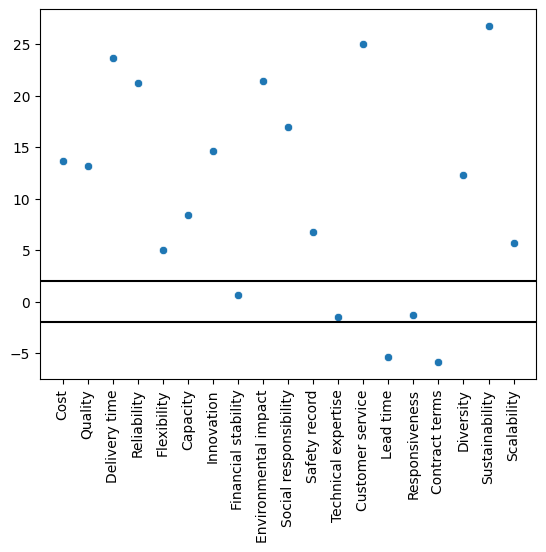

In [15]:
sns.scatterplot(corr*100)

plt.xticks(rotation=90)
plt.axhline(y = 2, color = 'black')
plt.axhline(y = -2, color = 'black')

### 4. Data Imbalance

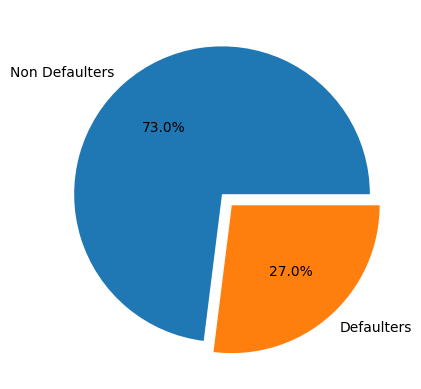

In [16]:
ax = plt.pie(DF['Supplier’s default'].value_counts(), labels=['Non Defaulters','Defaulters'],explode=[0,0.1],autopct='%1.1f%%')
plt.show()

## Data Processing

### 5. Convert category column 'Reputation' to Numerical Column using One Hot Enconding

In [17]:
encoder = OneHotEncoder(sparse_output=False)
encoded_data = encoder.fit_transform(DF[['Reputation']])
encoded_frame = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(), index=DF.index)
DF = pd.concat([DF.drop(columns=['Reputation']),encoded_frame.drop(columns=['Reputation_nan'],errors='ignore')],axis=1)

### 6. Split Data into Training & Test datasets

In [18]:
corr

Cost                     0.136620
Quality                  0.131968
Delivery time            0.236306
Reliability              0.212062
Flexibility              0.050189
Capacity                 0.084427
Innovation               0.145937
Financial stability      0.006376
Environmental impact     0.213635
Social responsibility    0.169080
Safety record            0.067317
Technical expertise     -0.015257
Customer service         0.250444
Lead time               -0.053470
Responsiveness          -0.013484
Contract terms          -0.058610
Diversity                0.122400
Sustainability           0.267519
Scalability              0.057022
dtype: float64

In [19]:
# splitting the data into features and target
# X = DF.drop(columns=['Financial stability', 'Technical expertise', 'Responsiveness' ,'Supplier’s default'])
# X = DF.drop(columns=['Financial stability', 'Supplier’s default'])
X = DF.drop(columns=['Supplier’s default'])
Y = DF['Supplier’s default']

In [20]:
# split into train and test data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 12)

## Modelling

### 7. Explore Different Models

In [21]:
# models = [
#           tree.DecisionTreeClassifier(), svm.SVC(), svm.LinearSVC(), GaussianNB(), RidgeClassifier(), LogisticRegression(), 
#           ExtraTreesClassifier(), RandomForestClassifier(), 
#           MLPClassifier(activation='relu', solver='adam', alpha=1e-5, hidden_layer_sizes=(100, 5), random_state=1, max_iter=9999)]

solvers = [
          svm.SVC(), svm.LinearSVC(), GaussianNB(), RidgeClassifier(), LogisticRegression(), 
          ExtraTreesClassifier(), RandomForestClassifier(), 
          MLPClassifier(activation='relu', solver='adam', alpha=1e-5, hidden_layer_sizes=(10, 3), random_state=1, max_iter=9999)]

models = []
for solver in solvers:
  models.append(CalibratedClassifierCV(solver))

### 8. Evaluation of Models

In [22]:
metrics_df = pd.DataFrame()
predictions = {}

  name = type(model.estimator).__name__

  # name = type(model).__name__ if (model.estimator is None) else model.estimator.__name__
  model.fit(X_train, Y_train)
  prediction = model.predict(X_test)
  tn, fp, fn, tp = metrics.confusion_matrix(Y_test, prediction).ravel()
  sensitivity = tp / (tp+fn)
  specificity = tn / (tn+fp)
  predictions[name] = prediction
  fpr, tpr, _ = metrics.roc_curve(Y_test, prediction)

  metrics_df.at[name,'Accuracy'] = metrics.accuracy_score(Y_test, prediction)
  metrics_df.at[name,'Sensitivity'] = sensitivity
  metrics_df.at[name,'Specificity'] = specificity
  metrics_df.at[name,'AUC'] = metrics.roc_auc_score(Y_test, prediction)
  metrics_df.at[name,'F1'] = metrics.f1_score(Y_test, prediction)
  metrics_df.at[name,'fpr_0'], metrics_df.at[name,'fpr_1'], metrics_df.at[name,'fpr_2']  = fpr
  metrics_df.at[name,'tpr_0'], metrics_df.at[name,'tpr_1'], metrics_df.at[name,'tpr_2']  = tpr

display(round(metrics_df,2))

,Accuracy,Sensitivity,Specificity,AUC,F1,fpr_0,fpr_1,fpr_2,tpr_0,tpr_1,tpr_2
SVC,0.85,0.61,0.95,0.78,0.71,0.0,0.05,1.0,0.0,0.61,1.0
LinearSVC,0.86,0.64,0.95,0.80,0.73,0.0,0.05,1.0,0.0,0.64,1.0
GaussianNB,0.85,0.63,0.94,0.78,0.71,0.0,0.06,1.0,0.0,0.63,1.0
RidgeClassifier,0.85,0.61,0.95,0.78,0.71,0.0,0.05,1.0,0.0,0.61,1.0
LogisticRegression,0.86,0.64,0.95,0.80,0.73,0.0,0.05,1.0,0.0,0.64,1.0
ExtraTreesClassifier,0.81,0.53,0.94,0.73,0.63,0.0,0.06,1.0,0.0,0.53,1.0
RandomForestClassifier,0.83,0.56,0.94,0.75,0.66,0.0,0.06,1.0,0.0,0.56,1.0
MLPClassifier,0.83,0.58,0.94,0.76,0.67,0.0,0.06,1.0,0.0,0.58,1.0


### 9. ROC Curve - All Models

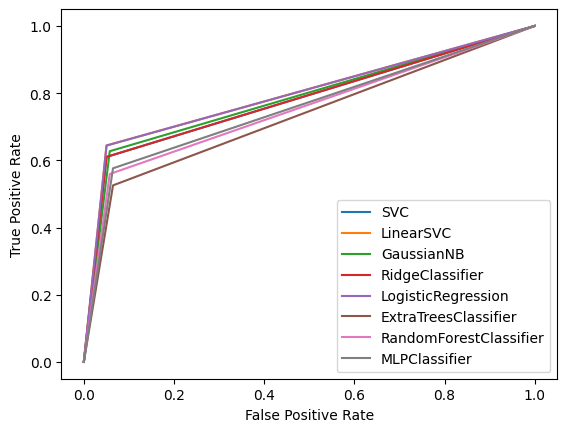

In [23]:
fig, ax = plt.subplots()
metrics_idx = metrics_df.index

for model in metrics_idx:
  metrics.RocCurveDisplay(
      fpr=[metrics_df.at[model,'fpr_0'],metrics_df.at[model,'fpr_1'],metrics_df.at[model,'fpr_2']], 
      tpr=[metrics_df.at[model,'tpr_0'],metrics_df.at[model,'tpr_1'],metrics_df.at[model,'tpr_2']]
    ).plot(ax=ax)

plt.legend(metrics_idx)
plt.show()

## 11. Predict Risk on New Supplier Data

In [24]:
new_df = pd.read_csv('new-supplier-data.csv')
new_df = new_df.set_index('Supplier ID')

encoded_data = encoder.transform(new_df[['Reputation']])
encoded_frame = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(), index=new_df.index)
new_df = pd.concat([new_df.drop(columns=['Reputation']),encoded_frame.drop(columns=['Reputation_nan'],errors='ignore')],axis=1)

best_model = models[1] # Linear SVC
print(best_model)

prob_df = pd.DataFrame(best_model.predict_proba(new_df), index=new_df.index)

CalibratedClassifierCV(estimator=LinearSVC())


In [25]:
new_df

,Cost,Quality,Delivery time,Reliability,Flexibility,Capacity,Innovation,Financial stability,Environmental impact,Social responsibility,Safety record,Technical expertise,Customer service,Lead time,Responsiveness,Contract terms,Diversity,Sustainability,Scalability,Reputation_Average,Reputation_Bad,Reputation_Excellent,Reputation_Good
Supplier ID,,,,,,,,,,,,,,,,,,,,,,,
Supplier 1,0.671,0.554,0.455,0.366,0.952,0.756,0.239,0.777,0.709,0.318,0.143,0.679,0.502,0.150,0.400,0.039,0.277,0.829,0.077,1.0,0.0,0.0,0.0
Supplier 2,0.674,0.393,0.688,0.507,0.693,0.469,0.338,0.619,0.388,0.823,0.204,0.118,0.757,0.256,0.488,0.007,0.977,0.835,0.566,0.0,1.0,0.0,0.0
Supplier 3,0.788,0.572,0.845,0.148,0.426,0.879,0.364,0.841,0.643,0.312,0.211,0.129,0.315,0.497,0.316,0.309,0.380,0.309,0.487,0.0,0.0,0.0,1.0
Supplier 4,0.848,0.368,0.481,0.773,0.172,0.206,0.154,0.763,0.744,0.984,0.919,0.500,0.450,0.546,0.452,0.108,0.317,0.005,0.737,1.0,0.0,0.0,0.0
Supplier 5,0.260,0.795,0.957,0.879,0.061,0.778,0.900,0.863,0.902,0.316,0.728,0.447,0.003,0.826,0.435,0.464,0.803,0.882,0.548,0.0,1.0,0.0,0.0


In [26]:
round(prob_df,2)

,0,1
Supplier ID,,
Supplier 1,0.84,0.16
Supplier 2,0.57,0.43
Supplier 3,0.95,0.05
Supplier 4,0.96,0.04
Supplier 5,0.49,0.51


In [27]:
## Probability of defaulting
prob_df[1]*100

Supplier ID
Supplier 1    16.064237
Supplier 2    42.606143
Supplier 3     4.974391
Supplier 4     4.085901
Supplier 5    51.461336
Name: 1, dtype: float64

## 12. Vivo Supplier Selection Problem

### Input Parameters

In [28]:
# Discounts matrix for each supplier/product
discounts = [
    [7, 22, 25, 34, 35],
    [30, 18, 18, 31, 26],
    [21, 30, 34, 12, 14],
    [27, 29, 30, 60, 6],
    [31, 25, 10, 13, 30],
    [23, 32, 15, 60, 9],
    [6, 21, 18, 60, 28],
    [17, 18, 6, 8, 31]
]

## Demand & list price of each product 
demand = [592, 446, 548, 647, 245, 797, 603, 401]
list_price = [870, 630, 960, 400, 980, 510, 830, 550]

fixed_admin_cost = 50000
risk_cost_rate = 80000
reliability = 0.8

num_product = len(discounts)
num_supplier = len(discounts[1])

discounted_price = np.zeros(40).reshape(num_product,num_supplier)
for i in range(num_product):
  for j in range(num_supplier):
    discounted_price[i][j] = (1-(discounts[i][j])/100) * list_price[i]

print(discounted_price)

# MIP solver with SCIP backend.
solver = pywraplp.Solver.CreateSolver('SCIP')

# Infinity constant
infinity = solver.infinity()

[[809.1 678.6 652.5 574.2 565.5]
 [441.  516.6 516.6 434.7 466.2]
 [758.4 672.  633.6 844.8 825.6]
 [292.  284.  280.  160.  376. ]
 [676.2 735.  882.  852.6 686. ]
 [392.7 346.8 433.5 204.  464.1]
 [780.2 655.7 680.6 332.  597.6]
 [456.5 451.  517.  506.  379.5]]


### Decision Variables

#### Binary Decision Variables - One for each supplier


In [29]:
y = {}
for j in range(num_supplier):
    y[j] = solver.IntVar(0, 1, 'y[%i]' % (j+1))
print(y)

{0: y[1], 1: y[2], 2: y[3], 3: y[4], 4: y[5]}


#### Decision variables for the quantity of ith Product from jth Supplier

In [30]:
x_var = {} 
k = 0
for i in range(num_product):
  x_var[i] = [solver.IntVar(0, infinity, 'X[%d][%d]' %((i+1),(j+1))) for j in range(num_supplier)]
 # k=k+1

print(x_var)
print(type(x_var))

import pandas as pd
pd_frame = pd.DataFrame.from_dict(x_var)
print(pd_frame.transpose())

print('Number of variables =', solver.NumVariables())

#x_var[i] = [solver.IntVar(0, infinity, 'Supplier %d, Product %d' %((i+1),(y+1))) for y in range(len(data_arr['requirements']))]

{0: [X[1][1], X[1][2], X[1][3], X[1][4], X[1][5]], 1: [X[2][1], X[2][2], X[2][3], X[2][4], X[2][5]], 2: [X[3][1], X[3][2], X[3][3], X[3][4], X[3][5]], 3: [X[4][1], X[4][2], X[4][3], X[4][4], X[4][5]], 4: [X[5][1], X[5][2], X[5][3], X[5][4], X[5][5]], 5: [X[6][1], X[6][2], X[6][3], X[6][4], X[6][5]], 6: [X[7][1], X[7][2], X[7][3], X[7][4], X[7][5]], 7: [X[8][1], X[8][2], X[8][3], X[8][4], X[8][5]]}
<class 'dict'>
         0        1        2        3        4
0  X[1][1]  X[1][2]  X[1][3]  X[1][4]  X[1][5]
1  X[2][1]  X[2][2]  X[2][3]  X[2][4]  X[2][5]
2  X[3][1]  X[3][2]  X[3][3]  X[3][4]  X[3][5]
3  X[4][1]  X[4][2]  X[4][3]  X[4][4]  X[4][5]
4  X[5][1]  X[5][2]  X[5][3]  X[5][4]  X[5][5]
5  X[6][1]  X[6][2]  X[6][3]  X[6][4]  X[6][5]
6  X[7][1]  X[7][2]  X[7][3]  X[7][4]  X[7][5]
7  X[8][1]  X[8][2]  X[8][3]  X[8][4]  X[8][5]
Number of variables = 45


### Constraints

In [31]:
# Creating reliability constraint
for i in range(num_product):
  for j in range(num_supplier):
    solver.Add(x_var[i][j] <= reliability*demand[i]*y[j])
    #p#rint(x_var[i][j])
    #print(demand[i])
   # print(y[j])

#Creating demand satisfaction constraint
for i in range(num_product):
  expr = [x_var[i][j] for j in range(num_supplier)]
  solver.Add(sum(expr) >= demand[i])
  #print(expr)
  #print(sum(expr))
  #print(demand[i])

print('Number of constraints =', solver.NumConstraints())

Number of constraints = 48


### Objective Terms

In [32]:
objective_terms = []
for i in range(num_product):
    for j in range(num_supplier):
        objective_terms.append((1-(discounts[i][j])/100) * list_price[i] * x_var[i][j])

for j in range(num_supplier):
    objective_terms.append(fixed_admin_cost  * y[j])

for k in range(num_supplier):
    objective_terms.append(risk_cost_rate  * prob_df[1][k] * y[k])

solver.Minimize(solver.Sum(objective_terms))

status = solver.Solve()

### Solution

In [42]:
if status == pywraplp.Solver.OPTIMAL:
  print('Minimum Cost Incurred to Satisfy Demand = %.2f' % solver.Objective().Value())
  print()
  solution_df = (pd.DataFrame(x_var, index=new_df.index)).applymap(pywraplp.Variable.solution_value)
  solution_df = solution_df[~(solution_df == 0).all(axis=1)]
  display(solution_df)
else:
  print('The problem does not have an optimal solution.')

Minimum Cost Incurred to Satisfy Demand = 1988693.60



,0,1,2,3,4,5,6,7
Supplier ID,,,,,,,,
Supplier 3,0.0,0.0,438.0,130.0,0.0,160.0,0.0,0.0
Supplier 4,119.0,356.0,0.0,517.0,49.0,637.0,482.0,81.0
Supplier 5,473.0,90.0,110.0,0.0,196.0,0.0,121.0,320.0
